# LSTM model dummy
Dummy model to predict the climate time series data

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error


2023-02-06 21:16:17.891549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 21:16:24.190329: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 21:16:24.190380: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 21:16:35.654641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Data Processing

Functions for plotting data and predicted values

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real time Dehli Climate')
    plt.plot(predicted, color='blue',label='Predicted Dehli Climate')
    plt.title('Dehli climate')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.legend()
    plt.show()

In [4]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

### Data Fetching and Cleaning

In [9]:
# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

In [4]:
#getting data
df_normal = pd.read_csv('../syn_CAN/train_1.csv', delimiter=',', index_col='Time')
df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/2)),:]


df_test_plat_ID1 = pd.read_csv('../syn_CAN/test_plateau.csv', delimiter=',', index_col='Time')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['Label','ID']],axis =1)


,Signal1_of_ID,Signal2_of_ID
Time,,
6.750704e+07,0.165060,0.25
6.750706e+07,0.165400,0.50
6.750707e+07,0.165821,0.75
6.750709e+07,0.166301,1.00
6.750710e+07,0.166662,0.00
...,...,...
7.200745e+07,0.617179,0.75
7.200746e+07,0.617330,1.00
7.200748e+07,0.617460,0.00


In [7]:
df_normal_grp_ID1

,Signal1,Signal2
Time,,
2.100476e+03,0.000000,0.00
2.115476e+03,0.000000,0.25
2.130476e+03,0.000000,0.50
2.145476e+03,0.000000,0.75
2.160476e+03,0.000000,1.00
...,...,...
7.765062e+06,0.707737,0.25
7.765077e+06,0.707857,0.50
7.765092e+06,0.707957,0.75


In [10]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1, df_normal_grp_ID1, TIME_STEP)

X_train.shape

(517446, 30, 2)

<AxesSubplot: >

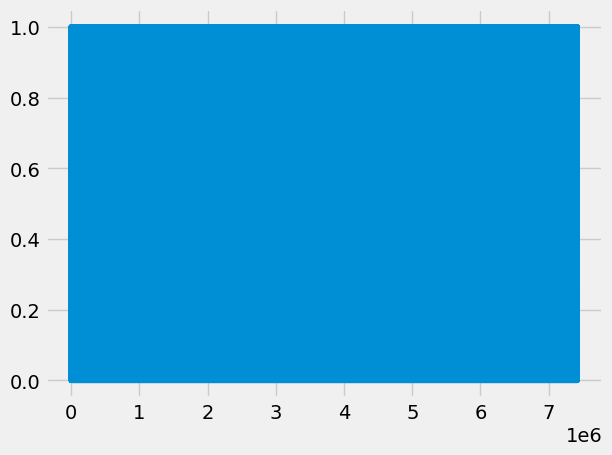

In [12]:

# df['meantemp'].plot()
# df['humidity'].plot()
# plt.legend(['Sig1','Sig2'])

# train_set=df[:'2016'].iloc[:,0]
# test_set=df['2016':].iloc[:,0]
# df_normal_grp_ID1['Signal1_of_ID'].head()
# plt.plot(df_normal_grp_ID1['Time'],df_normal_grp_ID1['Signal1_of_ID'])
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:500,:]
# fig = 
# len(df_normal_grp_ID1)
df_normal_grp_ID1['Signal2'].plot()

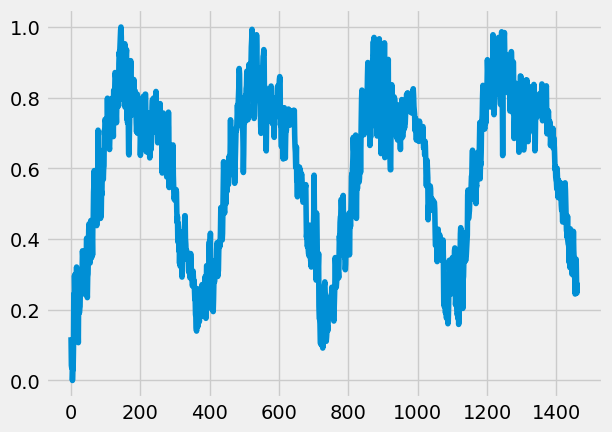

In [13]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_set)

plt.plot(training_set_scaled)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output,
So for each element of training set, we have 60 previous training set elements 

In [23]:
training_set_scaled.shape
print("training_set_scaled= "+ str(training_set_scaled))
X_train = []
y_train = []
for i in range(60,1461):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print("x_train= " + str(X_train))
print("y_train= "+str(y_train))

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print("x_train_reshaped= " + str(X_train))




training_set_scaled= [[0.12227074]
 [0.04279476]
 [0.0356623 ]
 ...
 [0.28238719]
 [0.24745269]
 [0.276718  ]]
x_train= [[0.12227074 0.04279476 0.0356623  ... 0.45240175 0.41048035 0.34643377]
 [0.04279476 0.0356623  0.08151383 ... 0.41048035 0.34643377 0.39737991]
 [0.0356623  0.08151383 0.         ... 0.34643377 0.39737991 0.40756914]
 ...
 [0.57546991 0.56667786 0.56197514 ... 0.34061135 0.33165939 0.34288969]
 [0.56667786 0.56197514 0.5418817  ... 0.33165939 0.34288969 0.28238719]
 [0.56197514 0.5418817  0.60034934 ... 0.34288969 0.28238719 0.24745269]]
y_train= [0.39737991 0.40756914 0.35458515 ... 0.28238719 0.24745269 0.276718  ]
x_train_reshaped= [[[0.12227074]
  [0.04279476]
  [0.0356623 ]
  ...
  [0.45240175]
  [0.41048035]
  [0.34643377]]

 [[0.04279476]
  [0.0356623 ]
  [0.08151383]
  ...
  [0.41048035]
  [0.34643377]
  [0.39737991]]

 [[0.0356623 ]
  [0.08151383]
  [0.        ]
  ...
  [0.34643377]
  [0.39737991]
  [0.40756914]]

 ...

 [[0.57546991]
  [0.56667786]
  [0.56

### Network structure

In [24]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

2023-01-13 16:04:24.560569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-13 16:04:24.572206: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-13 16:04:24.572272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arain): /proc/driver/nvidia/version does not exist
2023-01-13 16:04:24.825347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
44/44 [==============================] - 20s 197ms/step - loss: 0.0382
Epoch 2/50
44/44 [==============================] - 9s 200ms/step - loss: 0.0214
Epoch 3/50
44/44 [==============================] - 9s 210ms/step - loss: 0.0180
Epoch 4/50
44/44 [==============================] - 9s 206ms/step - loss: 0.0156
Epoch 5/50
44/44 [==============================] - 9s 204ms/step - loss: 0.0141
Epoch 6/50
44/44 [==============================] - 9s 213ms/step - loss: 0.0131
Epoch 7/50
44/44 [==============================] - 9s 211ms/step - loss: 0.0133
Epoch 8/50
44/44 [==============================] - 9s 200ms/step - loss: 0.0121
Epoch 9/50
44/44 [==============================] - 9s 214ms/step - loss: 0.0116
Epoch 10/50
44/44 [==============================] - 10s 231ms/step - loss: 0.0119
Epoch 11/50
44/44 [==============================] - 10s 213ms/step - loss: 0.0106
Epoch 12/50
44/44 [==============================] - 9s 197ms/step - loss: 0.0107
Epoch 13/50
44/44 [===

dataset_total= date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64
inputs= [[12.        ]
 [12.5       ]
 [11.25      ]
 [11.5       ]
 [12.75      ]
 [15.375     ]
 [17.125     ]
 [16.375     ]
 [15.5       ]
 [15.        ]
 [14.71428571]
 [14.        ]
 [14.375     ]
 [15.75      ]
 [15.83333333]
 [17.375     ]
 [17.125     ]
 [15.5       ]
 [15.85714286]
 [15.625     ]
 [15.75      ]
 [18.        ]
 [18.26666667]
 [15.5625    ]
 [13.        ]
 [13.6       ]
 [14.        ]
 [13.26666667]
 [12.35714286]
 [12.06666667]
 [12.1875    ]
 [11.73333333]
 [14.4375    ]
 [11.1875    ]
 [11.66666667]
 [14.5625    ]
 [17.58333333]
 [16.85714286]
 [19.5625    ]
 [20.14285714]
 [17.375     ]
 [15.84615385]
 [15.26666667]
 [13.125     ]
 [1

/home/abdul/.local/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


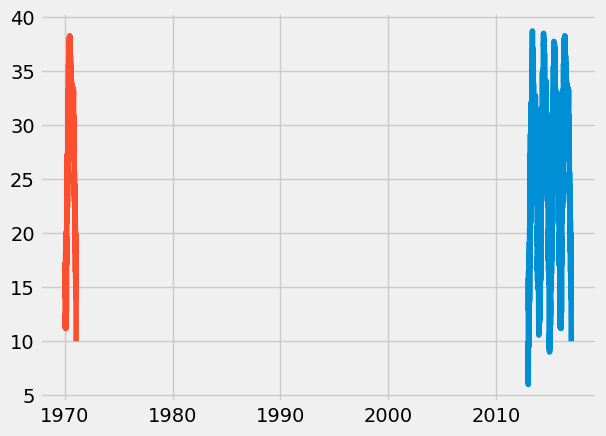

In [35]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((df["meantemp"][:'2016'],df["meantemp"]['2017':]),axis=0)
print("dataset_total= " + str(dataset_total))
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values #returns the array in numpy format
plt.plot(dataset_total)
plt.plot(inputs)
inputs = inputs.reshape(-1,1)
print( "inputs= "+ str(inputs))
inputs  = sc.transform(inputs)
print( "inputs_transform= "+ str(inputs))


8/8 [==============================] - 1s 47ms/step


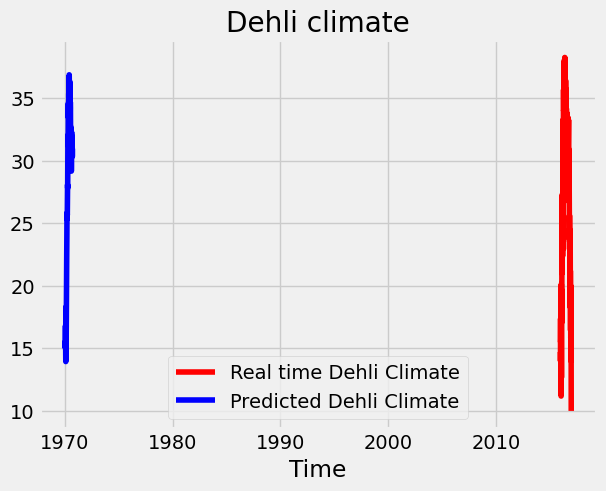

In [33]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_dehli_cli = regressor.predict(X_test)
predicted_dehli_cli = sc.inverse_transform(predicted_dehli_cli)


# Visualizing the results for LSTM
plot_predictions(test_set,predicted_dehli_cli)



